# Setup

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import HTML,clear_output
from importlib import reload

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.express as px
import plotly.graph_objects as go

from importData import import_all,generate_diffuse_tether_trajectories
import displayData
import trajAnalysis
import bayesianTools
from model_utils import GenerationMode
import model
from utils import notebook_setup_widgets
import tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
N_steps = 1000
N_particle=10

dt=1./30
T_stick= 200*dt
T_unstick= 200*dt
D= 0.3333
A= D*dt

df, model_params = tests.generateSynthTrajs(N_steps, N_particle, dt, T_stick, T_unstick, D, A)

<IPython.core.display.Javascript object>


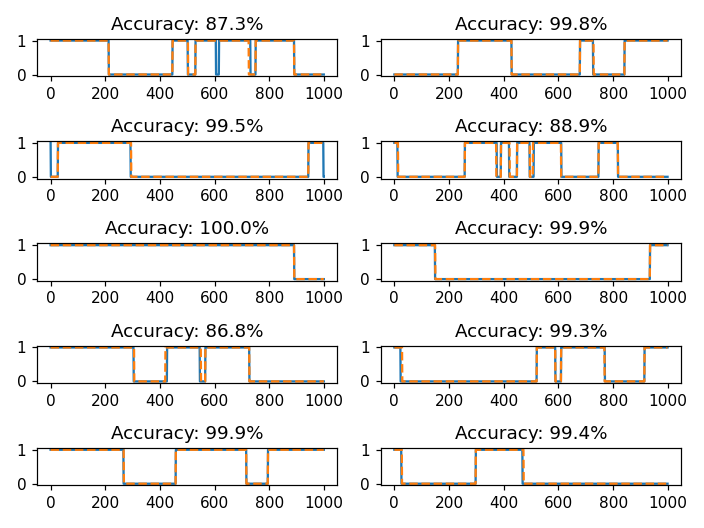

C:\Users\User\miniconda3\envs\diffusion\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [10]:
tests.compare_true_and_viterbi_paths(df, model_params)

In [32]:
import numpy as np
import scipy.ndimage.measurements as mnts

A = np.array([
    [1, 0, 0, 0],
    [0, 1, 1, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 0]
])
A = np.asarray([1])

# labeled is a version of A with labeled clusters:
#
# [[1 0 0 0]
#  [0 2 2 0]
#  [0 2 0 0]
#  [0 2 0 0]]
#
# clusters holds the number of different clusters: 2
labeled, clusters = mnts.label(A)

# sizes is an array of cluster sizes: [0, 1, 4]
sizes = mnts.sum(A, labeled, index=range(clusters + 1))

# mnts.sum always outputs a float array, so we'll convert sizes to int
sizes = sizes.astype(int)[1:]

# get an array with the same shape as labeled and the 
# appropriate values from sizes by indexing one array 
# with the other. See the `numpy` indexing docs for details
labeledBySize = sizes[labeled]

print(labeledBySize)

[1]


In [33]:
sizes

array([0, 1])

# Import a dataframe

## Import experimental data

*Note*: The first import after will include reading from .csv and saving to a binary feather file and might take a few minutes.

#### Select experiments and/or particles with the widgets:

In [ ]:
full_df = import_all();df = full_df.copy();
expSelectWidget,rdmEnableWidget,rdmSameVideoWidget,keepStuckWidget,rdmSelectionWidget,specificEnableWidget,specificParticleSelectionWidget,buttonFilterWidget,filterDataframesFun=notebook_setup_widgets(widgets)
expSelectWidget.options = full_df.experiment.unique(); specificParticleSelectionWidget.min = full_df.particle.min(); specificParticleSelectionWidget.max = full_df.particle.max(); buttonFilterWidget.on_click(lambda b: filterDataframesFun(full_df,df))    
display(expSelectWidget,widgets.HBox((widgets.VBox((rdmEnableWidget,keepStuckWidget)),widgets.VBox((rdmSelectionWidget,rdmSameVideoWidget)))),widgets.HBox((specificEnableWidget,specificParticleSelectionWidget)),buttonFilterWidget)

### Alternatively, create a synthetic dataframe:

In [ ]:
N_steps = 1000
N_particle=10

dt=1./30
T_stick= 200*dt
T_unstick= 200*dt
D= 0.3333
A= D*dt/5

generation_mode=GenerationMode.DONT_FORCE #keep this
init_S=None #random
do_post_processing=False #calculate some extra statistics, this takes a short while
undersample_ratio=0#0.1
save_files=False
is_parallel=False #relevant only if do_post_processing==True

model_params = model.pack_model_params(T_stick,T_unstick,D,A,dt) #for convenience

df=generate_diffuse_tether_trajectories(T_stick, T_unstick, D, A, dt, N_steps,  N_particle, init_S,
                                     do_post_processing,undersample_ratio, save_files, generation_mode, is_parallel)

true_df = df.copy()

#### Create heatmaps data for Amit

In [ ]:
reload(bayesianTools)

X_arr_list = bayesianTools.extract_X_arr_list_from_df(df)
dt_list = bayesianTools.extract_dt_list_from_df(df)


D_arr = np.logspace(-.5,.5,3)*D
A_arr = np.logspace(-.5,.5,3)*A
L_mat = np.zeros([len(D_arr),len(A_arr)])
for n,D_iter in enumerate(D_arr):
    for m,A_iter in enumerate(A_arr):
        L_mat[n,m]=bayesianTools.multiple_trajectories_likelihood(X_arr_list, dt_list, T_stick, T_unstick, D_iter, A_iter,
                                     is_parallel=True)

        print([n,m])
np.save("L_mat",L_mat)    

    
reload(bayesianTools)
T1_arr = np.logspace(-1.,3.,21)*T_stick
T2_arr = np.logspace(-1.,3.,21)*T_unstick
L_mat2 = np.zeros([len(T1_arr),len(T2_arr)])
for n,T1_iter in enumerate(T1_arr):
    for m,T2_iter in enumerate(T2_arr):
        L_mat2[n,m]=bayesianTools.multiple_trajectories_likelihood(X_arr_list, dt_list, T1_iter, T2_iter, D, A,
                                     is_parallel=True)

        print([n,m])
np.save("L_mat2",L_mat2)    
    

#### Check optimization stuff

In [ ]:
import time
X_arr_list = bayesianTools.extract_X_arr_list_from_df(df)
dt_list = bayesianTools.extract_dt_list_from_df(df)

def costFun(params):
#     TT_stick,TT_unstick,DD,AA = params
    DD,AA = params
    TT_stick = T_stick
    TT_unstick = T_unstick
    t = time.time()
    L = bayesianTools.multiple_trajectories_likelihood(X_arr_list, dt_list, TT_stick, TT_unstick, DD, AA,
                                     is_parallel=False)
    print("Params=[{},{},{},{}]; L={}; In {} sec".format(
    np.round(TT_stick,0),np.round(TT_unstick,0),np.round(DD,9),np.round(AA,9),np.round(L,9),np.round(time.time()-t,1)))
    return -L

In [ ]:
import scipy

res = scipy.optimize.minimize(costFun, [D*2,A/2])

In [ ]:
df.columns

#### Check that the Viterbi paths are close enough to the true paths

In [ ]:
N_rows = int(np.ceil(N_particle/2))
fig,ax=plt.subplots(N_rows,2)
reload(bayesianTools)

import time
from utils import profile

X_arr_list = bayesianTools.extract_X_arr_list_from_df(df)
dt_list = bayesianTools.extract_dt_list_from_df(df)

model_params = model.pack_model_params(T_stick,T_unstick,D,A,dt)
for i in range(N_particle):
    n = i % N_rows
    m = int(i/N_rows)
    X_arr = X_arr_list[i]
    t = time.time()
    S,XT,L_est = bayesianTools.viterbi_algorithm(X_arr,T_stick,T_unstick,D,A,dt_list[i],True)
    est_time = np.round(time.time()-t,2)
    fullState= [[S[j],X_arr[j],XT[j]] for j in range(N_steps)]

    S_true = df[df.particle==i].state.values
    XT_true = df[df.particle==i][["x_tether","y_tether"]].values

    fullState_true= [[S_true[j],X_arr[j],XT_true[j]] for j in range(N_steps)]
    L_tru = model.model_trajectory_log_probability(S_true,X_arr,model_params)
    
    print("Calculated in {} sec, L_tru = {}, L_est = {}".format(
    est_time,np.round(L_tru,3),np.round(L_est,3)))
    
    ax[n,m].plot(np.arange(N_steps),S_true,'-')
    ax[n,m].plot(np.arange(N_steps),S,'--')
plt.tight_layout()

In [ ]:
ax[n,m].set_title('yalla')

In [ ]:
np.sum(np.isclose(XT,XT_true, rtol=1e-05, atol=1e-08, equal_nan=True)) / float(N_steps)

In [ ]:
np.sum(np.prod(XT==XT,axis=1))

# Display Some Graphs

## Show trajectories

In [ ]:
startAtOrigin=False
if startAtOrigin:
    plotly_df=trajAnalysis.shift_traj_to_origin(df)
else:
    plotly_df = df.copy()
plotly_df.y *=-1
plotly_df["particle_state"] = plotly_df.particle.astype(str)+"_"+plotly_df.state.astype(str)
fig = px.line(plotly_df, x="x", y="y", color='particle_state',hover_data=['frame'],color_discrete_sequence=px.colors.qualitative.D3,)
fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
fig.show()

## Trajectories Animation:

In [ ]:
reload(displayData)
max_frame = 51
startAtOrigin=True
doneTrajNoMarker=True
dispLegend=False
if "Traj_fig" in locals() : plt.close(Traj_fig)
Traj_fig, Traj_ax = plt.subplots(figsize=(5,5))
drawnLines=displayData.plot_trajectories(df,curParticlePivotSize=5., t_end=max_frame, doneTrajNoMarker=doneTrajNoMarker,startAtOrigin=startAtOrigin,dispLegend=False, ax=Traj_ax, useDrawnLines=False, drawnLines=[],hideLines=True,axForVelocityPlot=[],particlesForFixedColoring = [])
def animateTraj(t_end):
    displayData.notebook_animate_traj(df,Traj_ax,t_end,max_frame,startAtOrigin=startAtOrigin,doneTrajNoMarker=doneTrajNoMarker,dispLegend=dispLegend,useDrawnLines=True,drawnLines=drawnLines,fps=0.,axForVelocityPlot=[],particlesForFixedColoring=[],curParticlePivotSize=5.)
ani = animation.FuncAnimation(Traj_fig, animateTraj, frames=max_frame); clear_output(wait=True); HTML(ani.to_jshtml())

## MSD Plot:

In [ ]:
default_groupby = "experiment"
if "MSD_fig" in locals() : plt.close(MSD_fig)
MSD_fig, MSD_ax = plt.subplots(figsize=(6, 4))
@interact(Log_Scale=True,group_by=["experiment","particle"],max_lagtime=(100,2000,10),N_sample_points = (2,101,1),equal_weight_per_particle=True)
#def update(group_by="experiment",Log_Scale=True,equal_weight_per_particle=True,step_lagtime=5,max_lagtime=100,):
def update(group_by=default_groupby,Log_Scale=False,equal_weight_per_particle=True,N_sample_points=21,max_lagtime=1000,):
    MSD_ax.cla()
    displayData.plot_MSD(df,isdfPadded=True, lagtime=np.unique(np.round(np.logspace(0,np.log10(max_lagtime),N_sample_points))), group_by=group_by, logscale=Log_Scale, ax=MSD_ax,eqParticleWeight=equal_weight_per_particle)
    MSD_ax.grid(True)

## Displacement Distribution $G(\Delta x,\Delta t)$:

In [ ]:
# set up plot
if "G_fig" in locals() : plt.close(G_fig)
G_fig, G_ax = plt.subplots(figsize=(6, 4))

dt_default = 3
xlim_default = 5.

@interact(dt=(1, min(200,df.frame.max()-1), 1),semiLogScale=True,direction=["xy", "x", "y"],group_by=["experiment","particle"],x_lim=(1., 30., 0.5),equal_weight_per_particle=True, clearAxes = True)
def update(dt=dt_default,x_lim=xlim_default,group_by="experiment",direction="xy",semiLogScale=True,equal_weight_per_particle=True,clearAxes = True):
    if clearAxes: G_ax.cla()        
    displayData.plot_G_dx_dt(df
                             ,isdfPadded=True, direction=direction, group_by=group_by, dt=dt, return_stats=False,semilogscale=semiLogScale,ax=G_ax,equal_particle_weight=equal_weight_per_particle)
    G_ax.set_xlim([-x_lim,x_lim])
    G_ax.set_ylim([1e-6,1e1]) if semiLogScale else G_ax.set_ylim([0,2.])   
    G_ax.grid(True)
    
#     sns.move_legend(G_ax,"lower left")
#     plt.setp(G_ax.get_legend().get_texts(), fontsize='7')  # for legend text
#     plt.setp(G_ax.get_legend().get_title(), fontsize='8')  # for legend title
